In [29]:
# import
import tensorflow as tf
import pandas as pd
import sklearn
import numpy as np
import re
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\28702\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data
train = pd.read_csv('./Corona_NLP_train.csv', encoding='latin-1')

In [3]:
# clean the original text by removing urls
def remove_url(original_tweet): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', original_tweet)

# clean the original text by removing punctuation
def remove_punctuation(text):
  # Use a regular expression to remove punctuation
  return re.sub(r'[^\w\s]', '', text)

# remove stopwords
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopwords(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

# convert text to lowercase
def to_lowercase(text):
  # Use a translator to convert the text to lowercase
  translator = str.maketrans('', '', string.ascii_lowercase)
  return text.translate(translator)

# remove special characters
def remove_special_characters(text):
  # Use a regular expression to remove special characters
  return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Define a function to stem a tweet
def stem_tweet(tweet):
  # Tokenize the tweet into individual words
  words = tweet.split()
  
  # Stem each word and return the result
  stemmed_words = [stemmer.stem(word) for word in words]
  return " ".join(stemmed_words)

# Sentiment prediction

In [4]:
# EDA
print(train.head)

sentiment = train['Sentiment']

mask = np.isin(sentiment, ['Extremely Negative'])
num_extremely_negative = np.count_nonzero(mask)
print('num_extremely_negative = ', num_extremely_negative)

mask = np.isin(sentiment, ['Negative'])
num_negative = np.count_nonzero(mask)
print('num_negative = ', num_negative)

mask = np.isin(sentiment, ['Neutral'])
num_neutral = np.count_nonzero(mask)
print('num_neutral = ', num_neutral)

mask = np.isin(sentiment, ['Positive'])
num_positive = np.count_nonzero(mask)
print('num_positive = ', num_positive)

mask = np.isin(sentiment, ['Extremely Positive'])
num_extremely_positive = np.count_nonzero(mask)
print('num_extremely_positive = ', num_extremely_positive)

<bound method NDFrame.head of        UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet           Sentiment  
0      @MeNyrb

In [5]:
# proprocess data
# clean data
train = train[['OriginalTweet', 'Sentiment']]
train.dropna()
train['OriginalTweet'] = train['OriginalTweet'].apply(remove_url)
train['OriginalTweet'] = train['OriginalTweet'].apply(remove_punctuation)
train['OriginalTweet'] = train['OriginalTweet'].apply(remove_stopwords)
train['OriginalTweet'] = train['OriginalTweet'].apply(to_lowercase)
train['OriginalTweet'] = train['OriginalTweet'].apply(remove_special_characters) 
train['OriginalTweet'] = train['OriginalTweet'].apply(stem_tweet)
tweets = train['OriginalTweet']
sentiment = train['Sentiment']

In [7]:
# bag-of-words model
# Create a vocabulary of all the unique words in the tweets
vectorizer = CountVectorizer()
vectorizer.fit(tweets)
vocabulary = vectorizer.vocabulary_
# Create a BoW model for each tweet
bow_models = vectorizer.transform(tweets)
# Stack the vectors for each tweet into a matrix
tweet_vectors = bow_models.toarray()

In [8]:
# convert sentiment to numerical values
# Create a label encoder
encoder = LabelEncoder()
# Fit the encoder to the sentiment dataset
encoded_sentiments = encoder.fit_transform(sentiment)

In [9]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(tweet_vectors, encoded_sentiments, test_size=0.2, random_state=42)

In [12]:
# Define the CNN architecture
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(tweet_vectors.shape[1], 1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training set
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10)

Epoch 1/10
1029/1029 [==============================] - 23s 22ms/step - loss: -3496387584.0000 - accuracy: 0.1608 - val_loss: -3920122112.0000 - val_accuracy: 0.1616
Epoch 2/10
1029/1029 [==============================] - 23s 22ms/step - loss: -4309819392.0000 - accuracy: 0.1608 - val_loss: -4817280000.0000 - val_accuracy: 0.1616
Epoch 3/10
1029/1029 [==============================] - 23s 22ms/step - loss: -5273696256.0000 - accuracy: 0.1608 - val_loss: -5868295680.0000 - val_accuracy: 0.1616
Epoch 4/10
1029/1029 [==============================] - 23s 23ms/step - loss: -6390118400.0000 - accuracy: 0.1608 - val_loss: -7072083968.0000 - val_accuracy: 0.1616
Epoch 5/10
1029/1029 [==============================] - 23s 22ms/step - loss: -7654317056.0000 - accuracy: 0.1608 - val_loss: -8426004480.0000 - val_accuracy: 0.1616
Epoch 6/10
1029/1029 [==============================] - 24s 24ms/step - loss: -9071614976.0000 - accuracy: 0.1608 - val_loss: -9938469888.0000 - val_accuracy: 0.1616
Epoc

In [34]:
# save the model
# Save the trained model
model.save('my_model.h5')

# Result: accuracy, loss, prediction performance, etc.

In [35]:
# use the model to make predictions on the test set
test = pd.read_csv('./Corona_NLP_train.csv', encoding='latin-1')
test = test[['OriginalTweet', 'Sentiment']]
tweets_test = test['OriginalTweet']
sentiment_test = test['Sentiment']

# Use the vectorizer to create BoW models for the testing set
bow_models_test = vectorizer.transform(tweets_test)

# Use the label encoder to encode the sentiments in the testing set
sentiments_test = encoder.transform(sentiment_test)

# Convert the sparse matrix to a dense matrix
bow_models_test = bow_models_test.toarray()

# Use the CNN to make predictions on the testing set
predictions = model.predict(bow_models_test)

# Convert the encoded sentiments to binary values
sentiments_test = (sentiments_test > 0.5).astype(int)
predicted_sentiments = (predictions > 0.5).astype(int)

# Convert the predicted probabilities to binary predictions (0 or 1)
predicted_sentiments = (predictions > 0.5).astype(int)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(sentiments_test, predicted_sentiments)

# Calculate the precision of the predictions
precision = precision_score(sentiments_test, predicted_sentiments)

# Calculate the recall of the predictions
recall = recall_score(sentiments_test, predicted_sentiments)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)

1287/1287 [==============================] - 6s 4ms/step
Accuracy:  0.8668270282090531
Precision:  0.8668270282090531
Recall:  1.0


# visualization

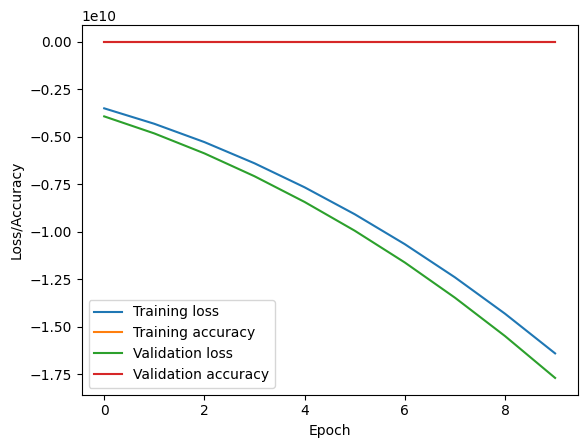

In [37]:
# Extract the loss and accuracy values for each epoch
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot the loss and accuracy values for each epoch
plt.plot(loss, label='Training loss')
plt.plot(accuracy, label='Training accuracy')
plt.plot(val_loss, label='Validation loss')
plt.plot(val_accuracy, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()